# Binary Classification Model with Telecom Churn Data

Highlights:
- Illustrates how to use the Explainable Boosting Machine (EBM) algorithm to develop and explain a classification model
- Provides a function that derives the Gain Capture metric and creates a dataframe to develop a Cumulative Gains curve

To Dos:
- Include other algorithms (sklearn, H2O, XG Boost, etc.)
- Explain the assessment criteria (gain capture, deciles, etc.)
- Explain why custom visualizations are created rather than using InterpretML's visualizations
- Figure out how to add a table of contents
- Add a date to the html document?

---

## Load Required Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
sns.set()

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

from interpret.glassbox import ExplainableBoostingClassifier

## Import and Prep Data

In [2]:
X, y = fetch_openml("telco-customer-churn", version=1, as_frame=True, return_X_y=True)

total_df = pd.concat([pd.DataFrame(y), X], axis=1)

del(X, y)

total_df.head()

,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,No,Female,0.0,Yes,No,1.0,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,No,Male,0.0,No,No,34.0,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5
2,Yes,Male,0.0,No,No,2.0,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15
3,No,Male,0.0,No,No,45.0,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,Yes,Female,0.0,No,No,2.0,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65


In [3]:
# Renaming variables for readability and case consistency
total_df = total_df.rename(columns={"gender":"Gender", "SeniorCitizen":"Senior Citizen", "tenure":"Tenure",
                                    "PhoneService":"Phone Service", "MultipleLines":"Multiple Lines",
                                    "InternetService":"Internet Service", "OnlineSecurity":"Online Security",
                                    "OnlineBackup":"Online Backup", "DeviceProtection":"Device Protection",
                                    "TechSupport":"Tech Support", "StreamingTV":"Streaming TV",
                                    "StreamingMovies":"Streaming Movies", "PaperlessBilling":"Paperless Billing",
                                    "PaymentMethod":"Payment Method", "MonthlyCharges":"Monthly Charges",
                                    "TotalCharges":"Total Charges"})

total_df['Total Charges'] = pd.to_numeric(total_df['Total Charges'], errors='coerce')
total_df['Senior Citizen'] = np.where(total_df['Senior Citizen'] == 1, 'Yes', 'No')

# Change the type of Tenure from float to integer
total_df['Tenure'] = total_df.Tenure.astype('int64')

total_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Churn              7043 non-null   object 
 1   Gender             7043 non-null   object 
 2   Senior Citizen     7043 non-null   object 
 3   Partner            7043 non-null   object 
 4   Dependents         7043 non-null   object 
 5   Tenure             7043 non-null   int64  
 6   Phone Service      7043 non-null   object 
 7   Multiple Lines     7043 non-null   object 
 8   Internet Service   7043 non-null   object 
 9   Online Security    7043 non-null   object 
 10  Online Backup      7043 non-null   object 
 11  Device Protection  7043 non-null   object 
 12  Tech Support       7043 non-null   object 
 13  Streaming TV       7043 non-null   object 
 14  Streaming Movies   7043 non-null   object 
 15  Contract           7043 non-null   object 
 16  Paperless Billing  7043 

In [4]:
# Investigate missing values for Total Charges

total_df['Binary Total Charges'] = np.where(total_df['Total Charges'].isnull(), 'Missing', 'Not Missing')

total_df['Binary Tenure'] = np.where(total_df.Tenure == 0, '0', '1+')

total_df.groupby(['Binary Total Charges', 'Binary Tenure', 'Churn']).size()

Binary Total Charges  Binary Tenure  Churn
Missing               0              No         11
Not Missing           1+             No       5163
                                     Yes      1869
dtype: int64

In [5]:
# It's reasonable to exclude the records with missing values.
total_df = total_df[~total_df['Total Charges'].isnull()]

total_df.drop(columns=['Binary Total Charges', 'Binary Tenure'], inplace=True)

total_df.describe(include='all')

,Churn,Gender,Senior Citizen,Partner,Dependents,Tenure,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges
count,7032,7032,7032,7032,7032,7032.000000,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032.000000,7032.000000
unique,2,2,2,2,2,NaN,2,3,3,3,3,3,3,3,3,3,2,4,NaN,NaN
top,No,Male,No,No,No,NaN,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,NaN,NaN
freq,5163,3549,5890,3639,4933,NaN,6352,3385,3096,3497,3087,3094,3472,2809,2781,3875,4168,2365,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,32.421786,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.798208,2283.300441
std,NaN,NaN,NaN,NaN,NaN,24.545260,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.085974,2266.771362
min,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,18.800000
25%,NaN,NaN,NaN,NaN,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.587500,401.450000
50%,NaN,NaN,NaN,NaN,NaN,29.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,1397.475000
75%,NaN,NaN,NaN,NaN,NaN,55.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.862500,3794.737500


In [6]:
# Assign a unique ID column for each record
total_df['CustomerID'] = total_df.index + 1

total_df = total_df[ ['CustomerID'] + [col for col in total_df.columns if col != 'CustomerID'] ]

total_df.head()

,CustomerID,Churn,Gender,Senior Citizen,Partner,Dependents,Tenure,Phone Service,Multiple Lines,Internet Service,...,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges
0,1,No,Female,No,Yes,No,1,No,No phone service,DSL,...,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,2,No,Male,No,No,No,34,Yes,No,DSL,...,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50
2,3,Yes,Male,No,No,No,2,Yes,No,DSL,...,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15
3,4,No,Male,No,No,No,45,No,No phone service,DSL,...,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,5,Yes,Female,No,No,No,2,Yes,No,Fiber optic,...,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65


## Train/Test Split using Stratified Random Sampling

In [7]:
train_df, test_df = train_test_split(total_df, train_size=3/4, stratify=total_df['Churn'], random_state=123)

X_train = train_df.drop(columns=['CustomerID', 'Churn'])
y_train = train_df['Churn']

X_test = test_df.drop(columns=['CustomerID', 'Churn'])
y_test = test_df['Churn']

print("Train Sample:   # Records = {:,}   # Features = {:,}   Churn Rate = {:.1f}%".format(X_train.shape[0],
                                                                                           X_train.shape[1],
                                                                                           (y_train=='Yes').mean()*100))

print("Test Sample:    # Records = {:,}   # Features = {:,}   Churn Rate = {:.1f}%".format(X_test.shape[0],
                                                                                           X_test.shape[1],
                                                                                           (y_test=='Yes').mean()*100))

Train Sample:   # Records = 5,274   # Features = 19   Churn Rate = 26.6%
Test Sample:    # Records = 1,758   # Features = 19   Churn Rate = 26.6%


## Train EBM Model

In [8]:
ebm_model = ExplainableBoostingClassifier(random_state=123, interactions=0)   # Setting interactions=0 to aid explainability
                                                                              
ebm_model.fit(X_train, y_train)

ExplainableBoostingClassifier(feature_names=['Gender', 'Senior Citizen',
                                             'Partner', 'Dependents', 'Tenure',
                                             'Phone Service', 'Multiple Lines',
                                             'Internet Service',
                                             'Online Security', 'Online Backup',
                                             'Device Protection',
                                             'Tech Support', 'Streaming TV',
                                             'Streaming Movies', 'Contract',
                                             'Paperless Billing',
                                             'Payment Method',
                                             'Monthly Charges',
                                             'Total Charges'],
                              feature_types=['categorical', 'categorical',
                                             'categorical', 'categoric

## Assess Model

In [9]:
scored_train_df = pd.DataFrame({'Series': 'Train',
                                'Truth' : y_train,
                                'Score' : ebm_model.predict_proba(X_train)[:,1]})

scored_test_df = pd.DataFrame({'Series': 'Test',
                               'Truth' : y_test,
                               'Score' : ebm_model.predict_proba(X_test)[:,1]})

scores_df = pd.concat([scored_train_df, scored_test_df])

scores_df

,Series,Truth,Score
4594,Train,Yes,0.450855
6624,Train,No,0.023913
5563,Train,No,0.149530
2951,Train,No,0.058773
2652,Train,No,0.552350
...,...,...,...
1171,Test,Yes,0.225875
4000,Test,No,0.657199
1797,Test,No,0.014196
173,Test,Yes,0.216369


In [10]:
def gains(input_df, series_var, truth_var, score_var):
    """
    This function serves two purposes:
        (1) Calculate the gain capture statistic for each model being evaluated in the input dataframe
        (2) Generate an output dataframe with x and y coordinates to produce a cumulative gains curve for each model
        
    Arguments:
        (1) input_df   --> Name of the dataframe that contains the additional three required arguments
        (2) series_var --> Column that identifies the model
        (3) truth_var  --> Column name of the target variable
        (4) score_var  --> Column name of the model score
        
        The input_df dataframe should contain one row for every model x record combination.
    
    Returns:
        (1) gain_statistics --> Gain capture statistic; one row for each model
        (2) gains_df        --> Dataframe with x and y coordinates to produce a cumulative gains curve
    
    Details:
    Gain Capture is defined to be the area under the gain curve, but above the baseline divided by the area under a
    perfect gain curve but above the baseline.  It is meant to represent the amount of potential gain "captured" by the
    model and was first widely-used in direct marketing applications.  This function mimics the gain_capture() function 
    from the yardstick R package (part of the tidymodels framework).
    """
    series_list = input_df[series_var].unique().tolist()
    
    gains_df = pd.DataFrame()
    gain_statistics = pd.DataFrame()
    
    for series in series_list:
        df = input_df[input_df[series_var] == series].sort_values(by=[score_var], ascending=False)
        
        num_obs = df.shape[0]
        num_positive = df[df[truth_var] == 'Yes'].shape[0]
        rate = num_positive / num_obs
        
        df['Pct_Sample'] = 1 / num_obs
        df['Pct_Target'] = (df[truth_var] == 'Yes') / num_positive
        
        df['CumPct_Sample'] = df['Pct_Sample'].cumsum(axis=0)
        df['CumPct_Target'] = df['Pct_Target'].cumsum(axis=0)
        
        df = df[[series_var, 'CumPct_Sample', 'CumPct_Target']]
        
        df = pd.concat([pd.DataFrame([[series, 0, 0]], columns=[series_var, 'CumPct_Sample', 'CumPct_Target']),
                        df], ignore_index = True)
        
        df['x_delta'] = df['CumPct_Sample'] - df['CumPct_Sample'].shift(periods=1, fill_value=0)
        df['y_delta'] = df['CumPct_Target'] - df['CumPct_Target'].shift(periods=1, fill_value=0)
        
        df['area_rectangle'] = df['x_delta'] * df['CumPct_Target'].shift(periods=1, fill_value=0)
        
        df['area_triangle'] = 0.5 * df['x_delta'] * df['y_delta']
        
        df['area_slice'] = df['area_rectangle'] + df['area_triangle']
        
        df = df[[series_var, 'CumPct_Sample', 'CumPct_Target', 'area_slice']]
               
        gains_df = pd.concat([gains_df, df], ignore_index=True)
        
        
        gain_capture = (sum(df['area_slice']) - 0.5) / (1 - (0.5 * rate) - 0.5)
            
        temp_gain_statistics = pd.DataFrame([{'Series'      : series,
                                             'Gain Capture': gain_capture}])
                
        gain_statistics = pd.concat([gain_statistics, temp_gain_statistics], ignore_index=True)
        
    return(gain_statistics, gains_df)

In [11]:
gain_stats_by_sample, gains_by_sample_df = gains(input_df = scores_df,
                                                 series_var = 'Series',
                                                 truth_var = 'Truth',
                                                 score_var = 'Score')

In [12]:
print(gain_stats_by_sample.to_string(index=False))

Series  Gain Capture
 Train      0.721826
  Test      0.675838


In [13]:
# Finalize data for gain capture plot

combined_df = pd.merge(gain_stats_by_sample, gains_by_sample_df, on=['Series'])

combined_df['Series'] = combined_df['Series'] + " (" + combined_df['Gain Capture'].apply("{:.02f}".format) + ")"

combined_df

,Series,Gain Capture,CumPct_Sample,CumPct_Target,area_slice
0,Train (0.72),0.721826,0.000000,0.000000,0.000000e+00
1,Train (0.72),0.721826,0.000190,0.000713,6.762104e-08
2,Train (0.72),0.721826,0.000379,0.001427,2.028631e-07
3,Train (0.72),0.721826,0.000569,0.002140,3.381052e-07
4,Train (0.72),0.721826,0.000758,0.002853,4.733473e-07
...,...,...,...,...,...
7029,Test (0.68),0.675838,0.997725,1.000000,5.688282e-04
7030,Test (0.68),0.675838,0.998294,1.000000,5.688282e-04
7031,Test (0.68),0.675838,0.998862,1.000000,5.688282e-04
7032,Test (0.68),0.675838,0.999431,1.000000,5.688282e-04


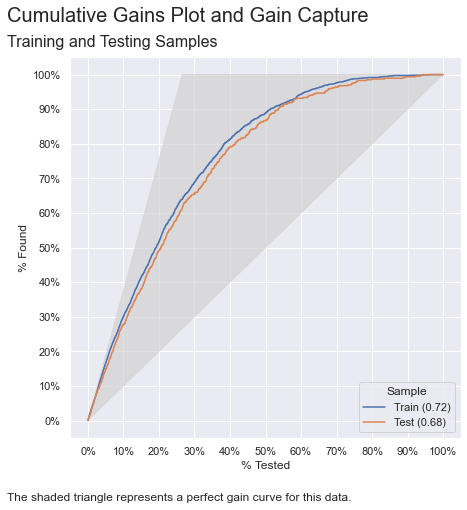

In [14]:
plot = plt.figure(figsize=(7,7))
plot = sns.lineplot(data=combined_df, x='CumPct_Sample', y='CumPct_Target', hue='Series')
plot.fill([0, (test_df['Churn'] == 'Yes').mean(), 1, 0], [0, 1, 1, 0], c='lightgrey', alpha=0.7)
plot.set_xlabel('% Tested')
plot.set_ylabel('% Found')
plot.legend(loc='lower right', title='Sample')
plot.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
plot.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
plot.set_xticks(np.arange(0, 1.1, 0.1))
plot.set_yticks(np.arange(0, 1.1, 0.1))
plt.figtext(0.0, 0.95, 'Cumulative Gains Plot and Gain Capture', fontsize=20)
plt.figtext(0.0, 0.90, 'Training and Testing Samples', fontsize=16)
plt.figtext(0.0, 0.0 , 'The shaded triangle represents a perfect gain curve for this data.', fontsize=12)
plt.show()

In [15]:
scored_test_df['Decile'] = 10 - pd.qcut(scored_test_df['Score'], 10, labels=False)

# Converting to 1/0 to calculate rates
scored_test_df['Truth'] = np.where(scored_test_df.Truth == 'Yes', 1, 0)

scored_test_df

,Series,Truth,Score,Decile
6666,Test,0,0.243972,5
3477,Test,0,0.512897,2
396,Test,0,0.449278,3
2465,Test,1,0.708741,1
6232,Test,1,0.799319,1
...,...,...,...,...
1171,Test,1,0.225875,5
4000,Test,0,0.657199,1
1797,Test,0,0.014196,10
173,Test,1,0.216369,5


In [16]:
scored_test_df.groupby('Decile').agg({"Score": ['count', 'min', 'max'],
                                      "Truth": ['sum', 'mean']})

Score                     Truth          
       count       min       max   sum      mean
Decile                                          
1        176  0.640960  0.905478   130  0.738636
2        176  0.495134  0.639685    99  0.562500
3        176  0.370110  0.494117    78  0.443182
4        175  0.269932  0.369943    62  0.354286
5        176  0.176733  0.266399    36  0.204545
6        176  0.106594  0.176174    30  0.170455
7        175  0.062943  0.105867    15  0.085714
8        176  0.033488  0.062320    11  0.062500
9        176  0.016026  0.033329     3  0.017045
10       176  0.004850  0.015998     3  0.017045

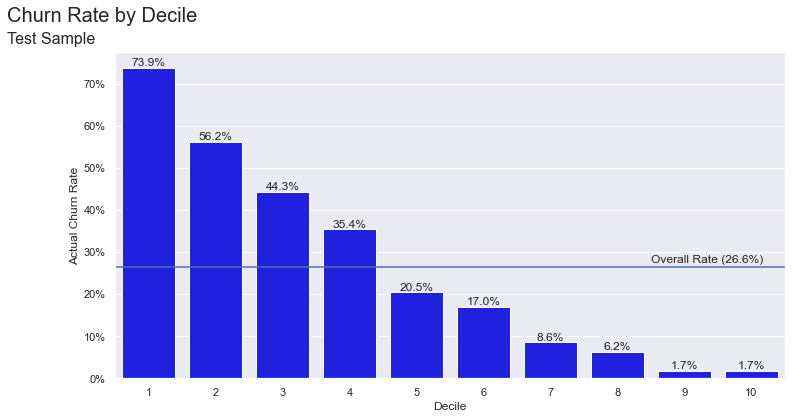

In [17]:
target_rate_by_decile_df = scored_test_df.groupby('Decile').agg(Target_Rate = ('Truth', 'mean'))

overall_rate = scored_test_df['Truth'].mean()*100

overall_rate_text = "Overall Rate ({:.1f}%)".format(overall_rate)

fig = plt.figure(figsize=(12, 6))
fig = sns.barplot(x=target_rate_by_decile_df.index,
                  y=target_rate_by_decile_df['Target_Rate']*100,
                  color='blue')
fig.bar_label(fig.containers[0], fmt='%.1f%%')
fig.axhline(overall_rate)
fig.text(7.5, overall_rate+1, overall_rate_text)
plt.figtext(0.0, 0.95, 'Churn Rate by Decile', fontsize=20)
plt.figtext(0.0, 0.90, 'Test Sample', fontsize=16)
fig.set(ylabel='Actual Churn Rate', xlabel='Decile')
fig.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))
plt.show()

del(target_rate_by_decile_df, overall_rate, overall_rate_text, fig)

## Global Feature Importance

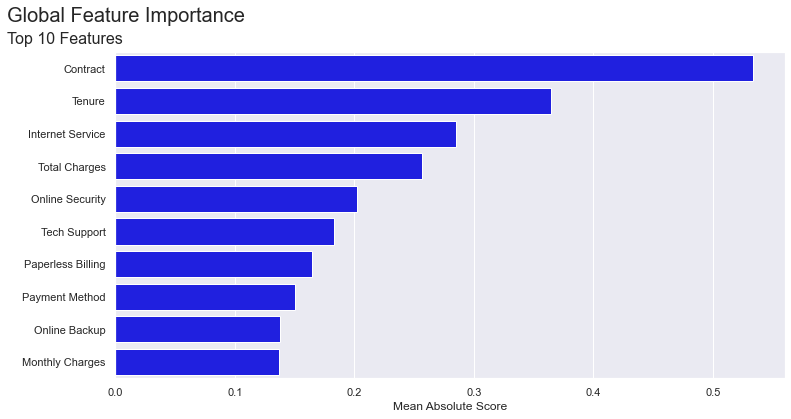

In [18]:
ebm_global = ebm_model.explain_global()

global_importance_df = pd.DataFrame(ebm_global.data()).sort_values(by=['scores'], ascending=False, ignore_index=True)

num_features_to_plot = 10

temp_df = global_importance_df[:num_features_to_plot]

plot = plt.figure(figsize=(12,6))
plot = sns.barplot(x=temp_df['scores'], y=temp_df['names'], color='blue')
plt.figtext(0.0, 0.95, 'Global Feature Importance', fontsize=20)
plt.figtext(0.0, 0.90, 'Top ' + str(num_features_to_plot) + ' Features', fontsize=16)
plot.set(ylabel='', xlabel='Mean Absolute Score')
plt.show()

del(ebm_global, global_importance_df, num_features_to_plot, temp_df, plot)

## Local Explanation

In [19]:
# Score the full dataset and format numeric variables for presentation

all_scores_df = pd.DataFrame(ebm_model.predict_proba(total_df[[c for c in ebm_model.feature_names]])[:, [1]],
                             columns=['model_score'])

total_scored_df = pd.concat([total_df.reset_index(drop=True),
                             all_scores_df.reset_index(drop=True)],
                            axis=1)

total_scored_df['Tenure'] = total_scored_df['Tenure'].apply("{:,.0f}".format)

dollar_vars = total_scored_df.columns[total_scored_df.columns.str.contains("Charges")]
for var in dollar_vars:
    total_scored_df[var] = "$" + total_scored_df[var].apply("{:,.2f}".format)

del(all_scores_df, dollar_vars, var)

total_scored_df.head()

,CustomerID,Churn,Gender,Senior Citizen,Partner,Dependents,Tenure,Phone Service,Multiple Lines,Internet Service,...,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,model_score
0,1,No,Female,No,Yes,No,1,No,No phone service,DSL,...,No,No,No,No,Month-to-month,Yes,Electronic check,$29.85,$29.85,0.646139
1,2,No,Male,No,No,No,34,Yes,No,DSL,...,Yes,No,No,No,One year,No,Mailed check,$56.95,"$1,889.50",0.045399
2,3,Yes,Male,No,No,No,2,Yes,No,DSL,...,No,No,No,No,Month-to-month,Yes,Mailed check,$53.85,$108.15,0.340990
3,4,No,Male,No,No,No,45,No,No phone service,DSL,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),$42.30,"$1,840.75",0.041140
4,5,Yes,Female,No,No,No,2,Yes,No,Fiber optic,...,No,No,No,No,Month-to-month,Yes,Electronic check,$70.70,$151.65,0.772166


In [20]:
# Derive labels for each variable x value

data_values_df = total_scored_df.melt(id_vars=['CustomerID', 'Churn', 'model_score'], 
                                      value_name='data_value', ignore_index=True).reset_index(drop=True)

data_values_df['label'] = data_values_df['variable'] + " = " + data_values_df['data_value']

# Records for the first CustomerID
data_values_df.sort_values(by='CustomerID')[:len(ebm_model.feature_names)].reset_index(drop=True)

,CustomerID,Churn,model_score,variable,data_value,label
0,1,No,0.646139,Gender,Female,Gender = Female
1,1,No,0.646139,Partner,Yes,Partner = Yes
2,1,No,0.646139,Monthly Charges,$29.85,Monthly Charges = $29.85
3,1,No,0.646139,Multiple Lines,No phone service,Multiple Lines = No phone service
4,1,No,0.646139,Online Security,No,Online Security = No
5,1,No,0.646139,Tech Support,No,Tech Support = No
6,1,No,0.646139,Total Charges,$29.85,Total Charges = $29.85
7,1,No,0.646139,Senior Citizen,No,Senior Citizen = No
8,1,No,0.646139,Contract,Month-to-month,Contract = Month-to-month
9,1,No,0.646139,Payment Method,Electronic check,Payment Method = Electronic check


In [21]:
# Derive explanation scores for each observation x variable combination

all_scores_df = pd.DataFrame(ebm_model.predict_and_contrib(total_df[[c for c in ebm_model.feature_names]])[1],
                             columns=ebm_model.feature_names)

explanation_scores_df = pd.concat([total_df[['CustomerID']].reset_index(drop=True),
                                   all_scores_df.reset_index(drop=True)],
                                  axis=1)

del(all_scores_df)

explanation_scores_df = explanation_scores_df.melt(id_vars='CustomerID', value_name='explanation_score')

explanation_scores_df

,CustomerID,variable,explanation_score
0,1,Gender,0.007028
1,2,Gender,-0.007093
2,3,Gender,-0.007093
3,4,Gender,-0.007093
4,5,Gender,0.007028
...,...,...,...
133603,7039,Total Charges,-0.139510
133604,7040,Total Charges,-0.337069
133605,7041,Total Charges,0.112789
133606,7042,Total Charges,0.154561


In [22]:
# Create final dataframe to create local explanation plots

local_explanation_df = pd.merge(data_values_df, explanation_scores_df, on=['CustomerID', 'variable'])

local_explanation_df['abs_explanation_score'] = abs(local_explanation_df.explanation_score)

# All records for first CustomerID
local_explanation_df.sort_values(by='CustomerID')[:len(ebm_model.feature_names)].reset_index(drop=True)

,CustomerID,Churn,model_score,variable,data_value,label,explanation_score,abs_explanation_score
0,1,No,0.646139,Gender,Female,Gender = Female,0.007028,0.007028
1,1,No,0.646139,Partner,Yes,Partner = Yes,-0.048631,0.048631
2,1,No,0.646139,Monthly Charges,$29.85,Monthly Charges = $29.85,-0.136037,0.136037
3,1,No,0.646139,Multiple Lines,No phone service,Multiple Lines = No phone service,0.061243,0.061243
4,1,No,0.646139,Online Security,No,Online Security = No,0.200765,0.200765
5,1,No,0.646139,Tech Support,No,Tech Support = No,0.184259,0.184259
6,1,No,0.646139,Total Charges,$29.85,Total Charges = $29.85,0.553197,0.553197
7,1,No,0.646139,Senior Citizen,No,Senior Citizen = No,-0.036747,0.036747
8,1,No,0.646139,Contract,Month-to-month,Contract = Month-to-month,0.483238,0.483238
9,1,No,0.646139,Payment Method,Electronic check,Payment Method = Electronic check,0.224123,0.224123


In [23]:
def explain_single_prediction(customer_id, num_features):
    truth = total_df[total_df['CustomerID'] == customer_id]['Churn'].item()
    
    temp_df = local_explanation_df[local_explanation_df['CustomerID'] == customer_id]
    temp_df = temp_df.sort_values(by='abs_explanation_score', ascending=False).head(num_features)
    temp_df['direction'] = np.where(temp_df['explanation_score'] > 0, 'positive', 'negative')
       
    plot = plt.figure(figsize=(12,6))
    plot = sns.barplot(x=temp_df['explanation_score'], y=temp_df['label'], hue=temp_df['direction'], 
                       palette={"positive": 'red', "negative": 'green'}, dodge=False)
    plot.get_legend().remove()
    plt.figtext(0.0, 0.95, 'Local Explanation for CustomerID ' + str(customer_id) + " (Actual Churn = " + str(truth) + ")", fontsize=20)
    plt.figtext(0.0, 0.90, 'Top ' + str(num_features) + " Features", fontsize=16)
    plot.set(ylabel='', xlabel='Explanation Score')
    plt.show()

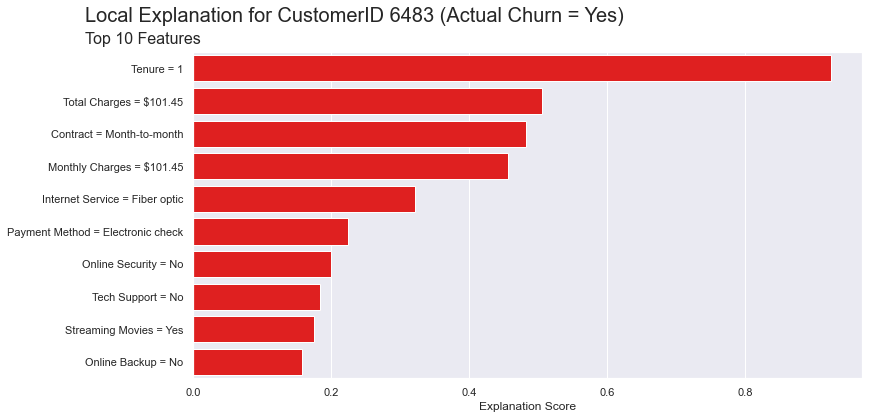

In [24]:
# Explanation for the record with the highest score

temp_customer = total_scored_df.sort_values(by='model_score', ascending=False).head(1)['CustomerID'].item()

explain_single_prediction(customer_id=temp_customer, num_features=10)

del(temp_customer)

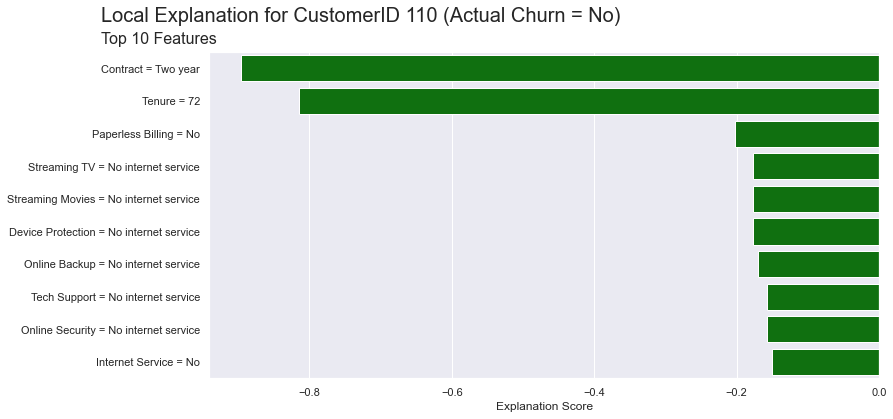

In [25]:
# Explanation for the record with the lowest score

temp_customer = total_scored_df.sort_values(by='model_score', ascending=True).head(1)['CustomerID'].item()

explain_single_prediction(customer_id=temp_customer, num_features=10)

del(temp_customer)

## Appendix

### Session Info for Reproducibility

In [26]:
import session_info

session_info.show()